In [1]:
## Import Libraries

import astropy as ap
import astropy.units as u
import astropy.wcs as wcs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import photutils
import scipy as sci
import sympy as sp

import csv
import os
import sys

from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.table import QTable, Table, Column
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from datetime import datetime

from numpy import format_float_scientific as sci

from photutils import detect_sources
from photutils import source_properties
from photutils import EllipticalAperture

from scipy import spatial

#plt.style.use(astropy_mpl_style)
%matplotlib inline
#mpl.use("pgf")
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

pd.set_option('display.max_columns', None)  # or 1000
#pd.set_option('display.max_rows', None)  # or 1000

In [2]:
def createFolder(directory): ##https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## Part One

In [3]:

# The columns in this table are: (these aren't the actual column names)

# (1) galaxy name
# (2) ratio of Hbeta flux to Halpha flux
# (3) note on Hbeta flux ratio
# (4) ratio of [OIII] 5007 flux to Halpha flux
# (5) note on [OIII] flux ratio
# (6) ratio of [OI] 6300 flux to Halpha flux
# (7) note on [OI] flux ratio
# (8) ratio of [NII] 6583 flux to Halpha flux
# (9) note on [NII] flux ratio
# (10) log of (the observed Halpha flux in units of erg/cm^2/s)
# (11) note on the log of the observed Halpha flux
# (12) log of (the Halpha luminosity in units of erg/s)
# (13) note on the log of the Halpha luminosity
# (14) equivalent width of the Halpha line (units of Angstroms)
# (15) note on the Halpha equivalent width
# (16) FWHM of the [NII] 6583 line (units of km/s)
# (17) note on the [NII] line width

# The notes mean:

#  L = 3 sigma lower limit
#  u = 3 sigma upper limit
#  s = line strength obtained by scaling the intensity of another line
#  b = value with substantial uncertainty of +/- 30-50%
#  c = value with very substantial uncertainty of +/- 100%

galaxOg = pd.read_csv("./dataTable1.csv",sep=',')
#df['[NII]6583 FWHM note']
#df.where(df.notnull(), None,inplace=True)
#galaxOG['[NII]6583 FWHM note'].fillna('', inplace=True)
galaxOg.replace(r'^\s*$', np.nan, regex=True,inplace=True)
galaxOg.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
display(galaxOg)

,galaxy,Hbeta,Hbeta note,[OIII]5007,[OIII]5007 note,[OI]6300,[OI]6300 note,[NII]6583,[NII]6583 note,log Halpha flux,log Halpha flux note,log Halpha lum,log Halpha lum note,Halpha width,Halpha width note,[NII]6583 FWHM,[NII]6583 FWHM note
0,IC 10,0.08,NaN,0.35,NaN,0.006,u,0.04,NaN,-12.72,NaN,37.59,NaN,1743.64,NaN,70,NaN
1,IC 239,1.47,u,1.47,u,0.590,u,0.59,c,-15.77,cL,36.76,cL,0.81,c,NaN,NaN
2,IC 342,0.13,NaN,0.01,NaN,0.007,NaN,0.45,NaN,-12.67,L,38.36,L,41.49,NaN,145,NaN
3,IC 356,0.1,c,0.24,NaN,0.110,NaN,1.68,NaN,-14.40,L,38.19,L,1.28,NaN,311,NaN
4,IC 467,0.17,NaN,0.07,NaN,0.058,NaN,0.44,NaN,-14.65,L,38.30,L,6.76,NaN,104,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NGC 7817,0.18,NaN,0.29,NaN,0.014,NaN,0.39,NaN,-13.25,NaN,39.83,NaN,70.12,NaN,133,NaN
414,UGC 3714,0.21,NaN,0.07,NaN,0.041,NaN,0.46,NaN,-13.66,NaN,39.64,NaN,10.66,NaN,195,NaN
415,UGC 3828,0.2,NaN,0.06,NaN,0.021,NaN,0.39,NaN,-13.36,NaN,40.06,NaN,31.35,NaN,199,NaN
416,UGC 4028,0.24,NaN,0.13,NaN,0.036,NaN,0.47,NaN,-13.75,NaN,39.77,NaN,14.22,NaN,194,NaN


In [4]:
galaxOgFilt = galaxOg.query(" `Hbeta` == `Hbeta` ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007` == `[OIII]5007` ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583` == `[NII]6583` ")
c = str('c')
b = str('b')
sb = str('sb')
galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @c ")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @b")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @sb")
#galaxOgFilt = galaxOgFilt.reset_index()
display(galaxOgFilt)

,galaxy,Hbeta,Hbeta note,[OIII]5007,[OIII]5007 note,[OI]6300,[OI]6300 note,[NII]6583,[NII]6583 note,log Halpha flux,log Halpha flux note,log Halpha lum,log Halpha lum note,Halpha width,Halpha width note,[NII]6583 FWHM,[NII]6583 FWHM note
0,IC 10,0.08,NaN,0.35,NaN,0.006,u,0.04,NaN,-12.72,NaN,37.59,NaN,1743.64,NaN,70,NaN
2,IC 342,0.13,NaN,0.01,NaN,0.007,NaN,0.45,NaN,-12.67,L,38.36,L,41.49,NaN,145,NaN
4,IC 467,0.17,NaN,0.07,NaN,0.058,NaN,0.44,NaN,-14.65,L,38.30,L,6.76,NaN,104,NaN
6,IC 1727,0.19,NaN,0.45,NaN,0.160,NaN,0.93,NaN,-14.21,NaN,37.69,NaN,2.12,NaN,176,NaN
7,IC 2574,0.18,NaN,0.04,NaN,0.025,u,0.07,NaN,-14.19,NaN,36.95,NaN,641,NaN,67,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NGC 7817,0.18,NaN,0.29,NaN,0.014,NaN,0.39,NaN,-13.25,NaN,39.83,NaN,70.12,NaN,133,NaN
414,UGC 3714,0.21,NaN,0.07,NaN,0.041,NaN,0.46,NaN,-13.66,NaN,39.64,NaN,10.66,NaN,195,NaN
415,UGC 3828,0.2,NaN,0.06,NaN,0.021,NaN,0.39,NaN,-13.36,NaN,40.06,NaN,31.35,NaN,199,NaN
416,UGC 4028,0.24,NaN,0.13,NaN,0.036,NaN,0.47,NaN,-13.75,NaN,39.77,NaN,14.22,NaN,194,NaN


In [5]:
#subtest = test[test['Hbeta note'] == 'u ']
#galaxOgFilt.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
#display(subtest)
#galaxOgFilt['Hbeta note'].unique()

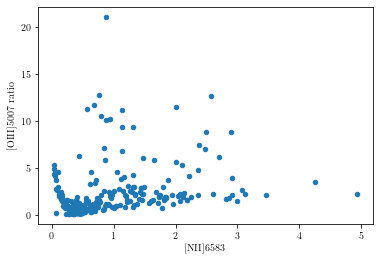

In [6]:
galaxOgFilt['[OIII]5007 ratio'] = galaxOgFilt['[OIII]5007'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)
#display(galaxOgFilt['[OIII]5007 ratio'])
#galaxOgFilt['[NII]6583 ratio'] = galaxOgFilt['[NII]6583'] / galaxOgFilt['Hbeta']

galaxOgFilt.plot(kind='scatter', x = '[NII]6583', y = '[OIII]5007 ratio')
#plt.show()

## Part Two

In [7]:
## For the files: 
## Column 1: Rest Frame Wavelength (angstrom)
## Column 2: Wavelength Flux Density ( 10^-15 erg/cm^2/s/angstrom )
s1 = pd.read_csv('./spectrum1.txt', sep = '    ',header=None, engine = "python")
s1.columns = ["Rest Wavelength","Flux Density"]
# display(s1)

s2 = pd.read_csv('./spectrum2.txt', sep = '    ',header=None, engine = "python")
s2.columns = ["Rest Wavelength","Flux Density"]
# display(s2)

s3 = pd.read_csv('./spectrum3.txt', sep = '    ',header=None, engine = "python")
s3.columns = ["Rest Wavelength","Flux Density"]
# display(s3)

s4 = pd.read_csv('./spectrum4.txt', sep = '    ',header=None, engine = "python")
s4.columns = ["Rest Wavelength","Flux Density"]
# display(s4)

s5 = pd.read_csv('./spectrum5.txt', sep = '    ',header=None, engine = "python")
s5.columns = ["Rest Wavelength","Flux Density"]
# display(s5)

s6 = pd.read_csv('./spectrum6.txt', sep = '    ',header=None, engine = "python")
s6.columns = ["Rest Wavelength","Flux Density"]
# display(s6)

s7 = pd.read_csv('./spectrum7.txt', sep = '    ',header=None, engine = "python")
s7.columns = ["Rest Wavelength","Flux Density"]
# display(s7)

s8 = pd.read_csv('./spectrum8.txt', sep = '    ',header=None, engine = "python")
s8.columns = ["Rest Wavelength","Flux Density"]
# display(s8)

s9 = pd.read_csv('./spectrum9.txt', sep = '    ',header=None, engine = "python")
s9.columns = ["Rest Wavelength","Flux Density"]
# display(s9)

s10 = pd.read_csv('./spectrum10.txt', sep = '    ',header=None, engine = "python")
s10.columns = ["Rest Wavelength","Flux Density"]
# display(s10)

In [8]:
p1 = pd.read_csv('./partner1.txt', sep = '    ',header=None, engine = "python")
p1.columns = ["Rest Wavelength","Flux Density"]
# display(p1)

p2 = pd.read_csv('./partner2.txt', sep = '    ',header=None, engine = "python")
p2.columns = ["Rest Wavelength","Flux Density"]
# display(p2)

p3 = pd.read_csv('./partner3.txt', sep = '    ',header=None, engine = "python")
p3.columns = ["Rest Wavelength","Flux Density"]
# display(p3)

p4 = pd.read_csv('./partner4.txt', sep = '    ',header=None, engine = "python")
p4.columns = ["Rest Wavelength","Flux Density"]
# display(p4)

p5 = pd.read_csv('./partner5.txt', sep = '    ',header=None, engine = "python")
p5.columns = ["Rest Wavelength","Flux Density"]
# display(p5)

p6 = pd.read_csv('./partner6.txt', sep = '    ',header=None, engine = "python")
p6.columns = ["Rest Wavelength","Flux Density"]
# display(p6)

p7 = pd.read_csv('./partner7.txt', sep = '    ',header=None, engine = "python")
p7.columns = ["Rest Wavelength","Flux Density"]
# display(p7)

p8 = pd.read_csv('./partner8.txt', sep = '    ',header=None, engine = "python")
p8.columns = ["Rest Wavelength","Flux Density"]
# display(p8)

p9 = pd.read_csv('./partner9.txt', sep = '    ',header=None, engine = "python")
p9.columns = ["Rest Wavelength","Flux Density"]
# display(p9)

p10 = pd.read_csv('./partner10.txt', sep = '    ',header=None, engine = "python")
p10.columns = ["Rest Wavelength","Flux Density"]
# display(p10)

In [9]:
display(s1)
display(p1)

,Rest Wavelength,Flux Density
0,6103.92,3.21674
1,6104.90,3.29237
2,6105.89,3.31321
3,6106.87,3.34650
4,6107.85,3.34201
...,...,...
646,6739.90,3.23150
647,6740.89,3.18981
648,6741.87,3.15680
649,6742.86,3.16134


,Rest Wavelength,Flux Density
0,6183.15,6.82180
1,6184.15,6.87760
2,6185.14,6.89104
3,6186.14,6.79389
4,6187.13,6.78293
...,...,...
646,6826.36,7.01036
647,6827.35,7.06450
648,6828.35,7.04894
649,6829.34,7.05802


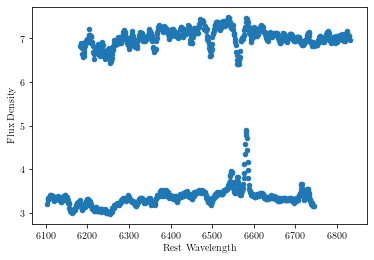

In [12]:
ax = s1.plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density')
p1.plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density', ax =ax)
plt.show()

In [ ]:
def trim(samp,part,verbose=False):
    plusle = samp['Rest Wavelength'].max ## Max value of spectra emmission lines
    minun = part['Rest Wavelength'].min ## Min Value of partner absorption lines 
    sampFilt = samp.query["`Rest Wavelength` >= @minun"]
    partFilt = part.query["`Rest Wavelength` <= @plusle"]
    return sampFilt, partFilt